In [17]:
import pandas as pd
from scipy.stats import ttest_ind, levene, bootstrap, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest


In [ ]:
!pip install pingouin
import pingouin as pg


### 데이터셋 설명

고객의 웹사이트 접속 데이터를 기반으로 한 A/B 테스트


### 사용한 기법

MannWhitneyu, T-test, levene, 시각화 등 



In [27]:
control_df = pd.read_csv('/kaggle/input/ab-testing-dataset/control_group.csv', sep = ';')
test_df = pd.read_csv('/kaggle/input/ab-testing-dataset/test_group.csv', sep = ';')
control_df = control_df.dropna()
control_df.head(5)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [28]:
test_df.drop(index = 4, inplace = True)
test_df.head(5)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
5,Test Campaign,6.08.2019,2458,42684,31489,7488,1854,1073,882,488


In [5]:
control_spend = control_df['Spend [USD]']
test_spend = test_df['Spend [USD]']


stat, p_value_levene = levene(test_spend, control_spend)
print("Levene's P-Value: ", p_value_levene)

Levene's P-Value:  0.8975585514162038


Levene's P-value가 0.89로 나타나 유의수준 0.05 하에서 두 그룹 간의 지출 액수가 통계적으로 유의미한 차이가 없다는 귀무가설을 기각하지 못하였다. <br>
따라서 두 그룹의 분산이 같다는 가정할 수 있으며 이에 따라 일반 t-검정을 수행한다

In [6]:
t_stat, p_value_two_sided = ttest_ind(test_spend, control_spend, equal_var = True)
p_value_one_sided = p_value_two_sided / 2
print("T_Statistic: ", t_stat)
print("P_Value_two_sided: ", p_value_two_sided)
print("P_Value_one_sided: ", p_value_one_sided)

T_Statistic:  2.793240375594836
P_Value_two_sided:  0.007093062303374369
P_Value_one_sided:  0.0035465311516871844


유의수준 0.05하에서 Test_group은 Control_group보다 통계적으로 유의미하게 큽니다.<br>
이제 Cohen's d 검정을 통해 어느 정도로 차이가 있는지 알아보겠습니다.

In [39]:
cohens_d = pg.compute_effsize(test_spend, control_spend, eftype = 'cohen')
print(cohens_d)

0.7274023345236823


cohen's d 값이 0.72 정도로 중간 정도의 크기 차이를 지님을 알 수 있습니다 <br>
이번엔 차이를 히스토그램을 통해 시각화해보겠습니다.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


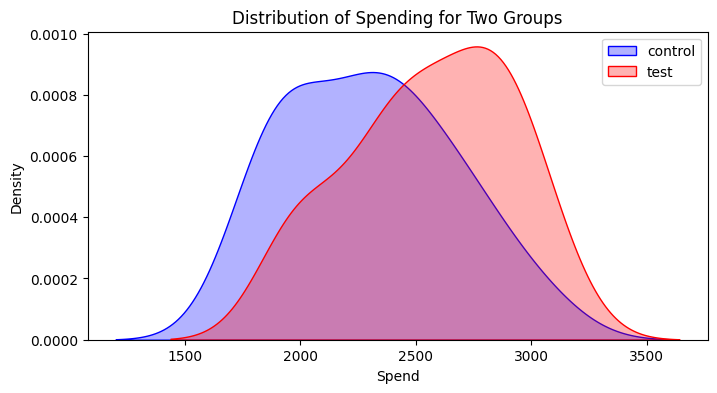

In [48]:
plt.figure(figsize = (8, 4))
sns.kdeplot(control_spend, color = 'blue', label = 'control', fill = True, alpha =0.3)
sns.kdeplot(test_spend, color = 'red', label = 'test', fill = True,  alpha = 0.3)
plt.legend()
plt.title("Distribution of Spending for Two Groups")
plt.xlabel("Spend")
plt.ylabel("Density")
plt.show()


In [51]:
def bootstrap(data1, data2, n_iterations = 1000 ):
    diffs = []
    for _ in range(n_iterations):
        sample1 = np.random.choice(data1, size = len(data1), replace= True)
        sample2 = np.random.choice(data2, size = len(data2), replace=  True)
        diffs.append(np.mean(sample1) - np.mean(sample2))

    return diffs


diffs = bootstrap(test_spend, control_spend)
lower = np.percentile(diffs, 2.5)
upper = np.percentile(diffs, 97.5)
print("95% Confidence Interval for Differnce: ", (lower, upper))

95% Confidence Interval for Differnce:  (70.50267241379325, 441.98787356321816)


In [60]:
u_stat, p_value = mannwhitneyu(test_spend, control_spend, alternative = 'greater')


print("Mann-Whitney U Statistic:", u_stat)
print("P-Value:", p_value)


Mann-Whitney U Statistic: 613.0
P-Value: 0.003559262187824425


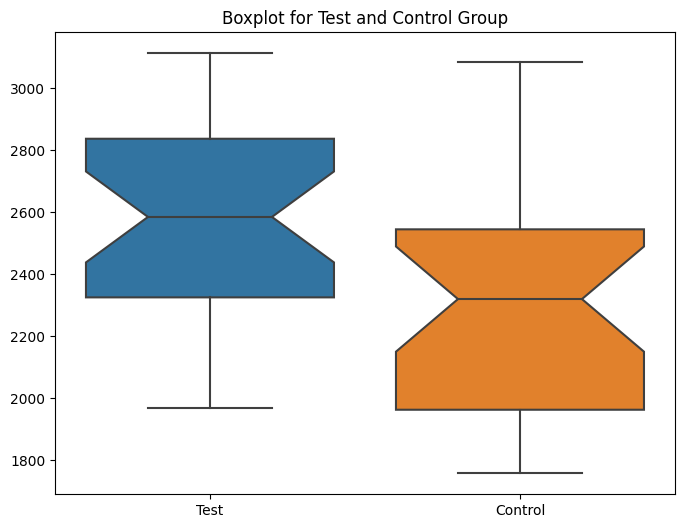

In [66]:
plt.figure(figsize = (8, 6))
sns.boxplot(data = [test_spend, control_spend], notch = True)
plt.xticks([0,1], ['Test', 'Control'])
plt.title("Boxplot for Test and Control Group")
plt.show()

In [67]:
effect_size = pg.compute_effsize(test_spend, control_spend, eftype = 'hedges')

print("Hedges' g:", effect_size)


Hedges' g: 0.7177890878119156


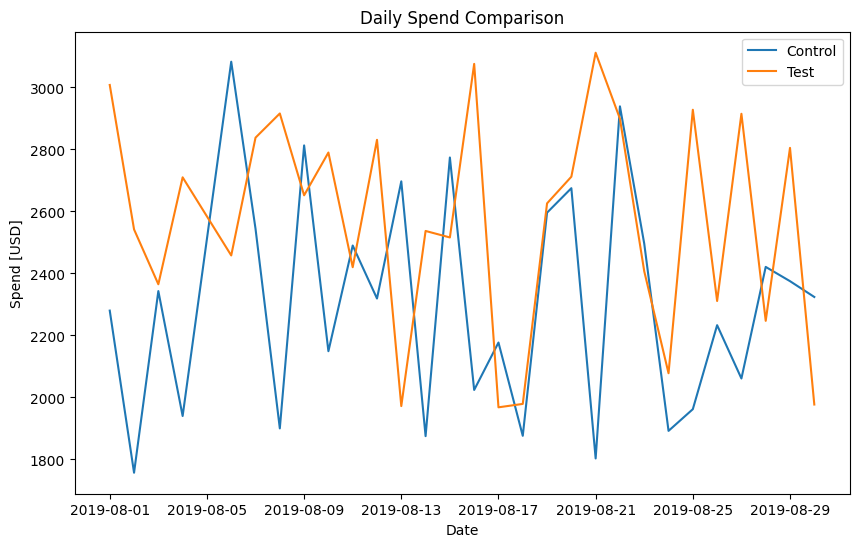

In [32]:
control_df['Date'] = pd.to_datetime(control_df['Date'], format = "%d.%m.%Y" )
test_df['Date'] = pd.to_datetime(test_df['Date'], format = "%d.%m.%Y")


plt.figure(figsize = (10, 6))
plt.plot(control_df['Date'], control_df['Spend [USD]'], label = 'Control')
plt.plot(test_df['Date'], test_df['Spend [USD]'], label = 'Test')
plt.legend()
plt.title("Daily Spend Comparison")
plt.xlabel("Date")
plt.ylabel("Spend [USD]")
plt.show()

In [38]:
control_df['Conversion Rate'] = control_df['# of Purchase'] / control_df['# of Website Clicks']
test_df['Conversion Rate'] = test_df['# of Purchase'] / test_df['# of Website Clicks']

control_conversion = control_df['Conversion Rate']
test_conversion = test_df['Conversion Rate']


stat, p_value = levene(test_conversion, control_conversion)

print(p_value)


0.06676830375418906


In [40]:
t_stat, t_p_value = ttest_ind(test_conversion, control_conversion, equal_var = False)
print(t_p_value)

t_stat, t_p_value = ttest_ind(test_conversion, control_conversion, equal_var = True)
print(t_p_value)


mw_stat, mw_p_value = mannwhitneyu(test_conversion, control_conversion, alternative = 'two-sided')
print(mw_p_value)

0.1232317433765193
0.12232465596172483
0.26284444131653684


In [41]:
control_success = control_df['# of Purchase'].sum()
test_success = test_df['# of Purchase'].sum()
control_total = control_df['# of Website Clicks'].sum()
test_total = test_df['# of Website Clicks'].sum()

z_stat, p_value = proportions_ztest( [control_success, test_success], [control_total, test_total], 
                                    alternative = 'larger')

print("Z-Statistic:", z_stat)
print("P-Value:", p_value)


Z-Statistic: 13.274085284838717
P-Value: 1.6362130934318786e-40


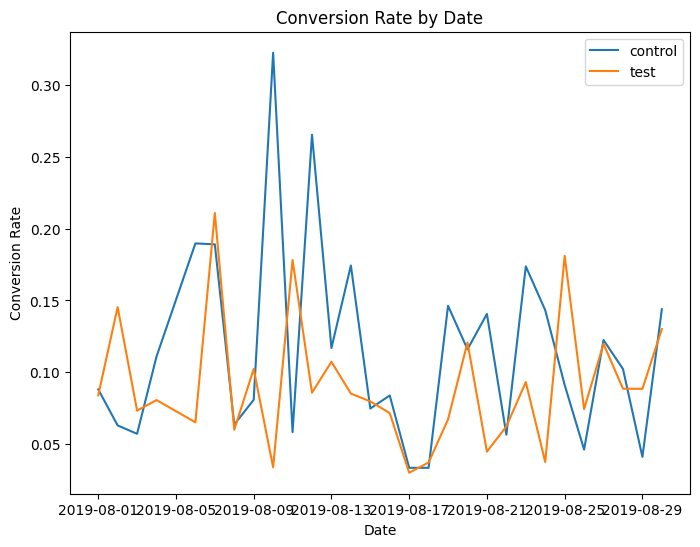

In [42]:
plt.figure(figsize = (8, 6))
plt.plot(control_df['Date'] , control_df['Conversion Rate'] , label = 'control')
plt.plot(test_df['Date'] , test_df['Conversion Rate'] , label = 'test')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Date')
plt.legend()
plt.show()

날짜별로는 conversion rate에 통계적으로 유의미한 차이가 없으나 전체적으로 보면 control group이 많다